In [461]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [462]:
spark = SparkSession.builder.getOrCreate()

In [463]:
# Import data from csv
df = spark.read.csv("births.csv", header = True, inferSchema = True)
df_train, df_test = df.randomSplit([0.8, 0.2], seed = 408)

In [464]:
# Select Feature
df_train = df_train.select("INFANT_ALIVE_AT_REPORT", "INFANT_SEX", "CIG_BEFORE", "ANESTHESIA", "STEROIDS", 
                           "MOTHER_BMI_RECODE", "ANTIBIOTICS", "DIABETES_GEST", "APGAR_5")
df_test = df_test.select("INFANT_ALIVE_AT_REPORT", "INFANT_SEX", "CIG_BEFORE", "ANESTHESIA", "STEROIDS", 
                           "MOTHER_BMI_RECODE", "ANTIBIOTICS", "DIABETES_GEST", "APGAR_5")

In [465]:
# Filter yang NA
df_train = df_train.dropna()
df_test = df_test.dropna()

In [466]:
# Transform Data
df_train = df_train.withColumn("INFANT_ALIVE_AT_REPORT", when(df_train["INFANT_ALIVE_AT_REPORT"] == "N", 0)
                                                        .when(df_train["INFANT_ALIVE_AT_REPORT"] == "Y", 1)
                              )

df_train = df_train.withColumn("INFANT_SEX", when(df_train["INFANT_SEX"] == "F", 0)
                                            .when(df_train["INFANT_SEX"] == "M", 1)
                              )

df_train = df_train.withColumn("ANESTHESIA", when(df_train["ANESTHESIA"] == "N", 0)
                                            .when(df_train["ANESTHESIA"] == "Y", 1)
                                            .when(df_train["ANESTHESIA"] == "U", 2)
                              )

df_train = df_train.withColumn("STEROIDS",   when(df_train["STEROIDS"] == "N", 0)
                                            .when(df_train["STEROIDS"] == "Y", 1)
                                            .when(df_train["STEROIDS"] == "U", 2)
                              )

df_train = df_train.withColumn("ANTIBIOTICS",   when(df_train["ANTIBIOTICS"] == "N", 0)
                                               .when(df_train["ANTIBIOTICS"] == "Y", 1)
                                               .when(df_train["ANTIBIOTICS"] == "U", 2)
                              )

df_train = df_train.withColumn("DIABETES_GEST", when(df_train["DIABETES_GEST"] == "N", 0)
                                               .when(df_train["DIABETES_GEST"] == "Y", 1)
                                               .when(df_train["DIABETES_GEST"] == "U", 2)
                              )


df_test = df_test.withColumn("INFANT_ALIVE_AT_REPORT", when(df_test["INFANT_ALIVE_AT_REPORT"] == "N", 0)
                                                      .when(df_test["INFANT_ALIVE_AT_REPORT"] == "Y", 1)
                              )

df_test = df_test.withColumn("INFANT_SEX",   when(df_test["INFANT_SEX"] == "F", 0)
                                            .when(df_test["INFANT_SEX"] == "M", 1)
                              )

df_test = df_test.withColumn("ANESTHESIA",   when(df_test["ANESTHESIA"] == "N", 0)
                                            .when(df_test["ANESTHESIA"] == "Y", 1)
                                            .when(df_test["ANESTHESIA"] == "U", 2)
                              )

df_test = df_test.withColumn("STEROIDS",     when(df_test["STEROIDS"] == "N", 0)
                                            .when(df_test["STEROIDS"] == "Y", 1)
                                            .when(df_test["STEROIDS"] == "U", 2)
                              )

df_test = df_test.withColumn("ANTIBIOTICS",     when(df_test["ANTIBIOTICS"] == "N", 0)
                                               .when(df_test["ANTIBIOTICS"] == "Y", 1)
                                               .when(df_test["ANTIBIOTICS"] == "U", 2)
                              )

df_test = df_test.withColumn("DIABETES_GEST",   when(df_test["DIABETES_GEST"] == "N", 0)
                                               .when(df_test["DIABETES_GEST"] == "Y", 1)
                                               .when(df_test["DIABETES_GEST"] == "U", 2)
                              )

In [467]:
# Preprocessing Data
cols = df_train.columns

# Normalization
cols.remove("INFANT_ALIVE_AT_REPORT")

df_train = VectorAssembler(inputCols = cols, outputCol = "VectorOut").transform(df_train)
df_train = StandardScaler(inputCol = "VectorOut", outputCol = "features").fit(df_train).transform(df_train)

df_test = VectorAssembler(inputCols = cols, outputCol = "VectorOut").transform(df_test)
df_test = StandardScaler(inputCol = "VectorOut", outputCol = "features").fit(df_test).transform(df_test)

In [468]:
# Display Features
df_train.select("features").show(truncate=False)

+----------------------------------------------------------------------------------------------------------+
|features                                                                                                  |
+----------------------------------------------------------------------------------------------------------+
|(8,[0,4,5],[2.004051141118474,1.5274261232028263,2.2834315969605097])                                     |
|(8,[0,4,5,7],[2.004051141118474,1.5274261232028263,2.2834315969605097,0.12097854947423477])               |
|(8,[4,7],[1.0182840821352175,0.060489274737117384])                                                       |
|(8,[0,2,4,7],[2.004051141118474,2.012177507746448,1.0182840821352175,5.988438198974621])                  |
|(8,[1,4,7],[0.634369170235483,1.0182840821352175,0.12097854947423477])                                    |
|(8,[2,4,7],[2.012177507746448,1.0182840821352175,0.060489274737117384])                                   |
|(8,[2,4,7],[2.0121

In [469]:
# Model
model = LogisticRegression(featuresCol = "features", labelCol = "INFANT_ALIVE_AT_REPORT", maxIter = 100).fit(df_train)

In [470]:
# Make the predict_result
predict_result = model.transform(df_test)

In [471]:
# Evaluate
evaluator = BinaryClassificationEvaluator(labelCol = "INFANT_ALIVE_AT_REPORT")

print(f"{evaluator.evaluate(predict_result)}%")

0.733725406330195%


In [472]:
predict_result = predict_result.toPandas()

In [473]:
import matplotlib.pyplot as plt

In [474]:
# Visualization

anesthesia_death = 0
anesthesia_alive = 0

antibiotics_death = 0
antibiotics_alive = 0

survived = 0
not_survived = 0

for index, row in predict_result.iterrows():
    if row["prediction"] == 1:
        survived += 1
        if row["ANESTHESIA"] == 1:
            anesthesia_alive += 1
        if row["ANTIBIOTICS"] == 1:
            antibiotics_alive += 1
    else:
        not_survived += 1
        if row["ANESTHESIA"] == 1:
            anesthesia_death += 1
        if row["ANTIBIOTICS"] == 1:
            antibiotics_death += 1

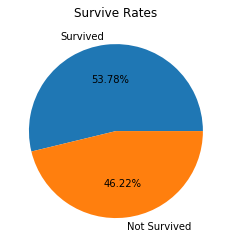

In [475]:
# Pie Chart
amount = [survived, not_survived]

plt.title("Survive Rates")
plt.pie(amount, labels=["Survived", "Not Survived"], autopct = "%.2f%%")
plt.show()

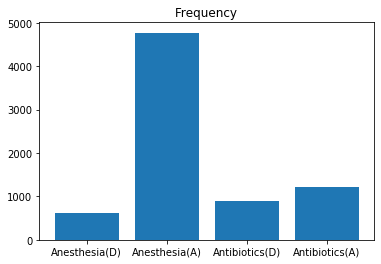

In [476]:
# Bar Chart
amount = [anesthesia_death, anesthesia_alive, antibiotics_death, antibiotics_alive,]

plt.title("Frequency")
plt.bar(["Anesthesia(D)", "Anesthesia(A)", "Antibiotics(D)", "Antibiotics(A)"], amount)
plt.show()

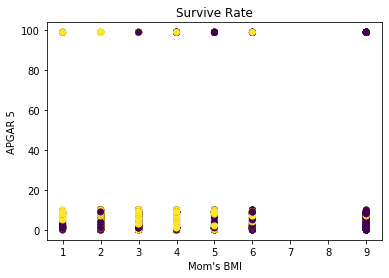

In [477]:
# Scatter plot
plt.title("Survive Rate")
plt.xlabel("Mom's BMI")
plt.ylabel("APGAR 5")
plt.scatter(predict_result["MOTHER_BMI_RECODE"], predict_result["APGAR_5"], c = predict_result["prediction"])